In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

In [2]:
reviews_df = pd.read_csv("D:\\Agentic_AI\\Capstone\\data\\app_store_reviews.csv")
emails_df = pd.read_csv('D:\\Agentic_AI\\Capstone\\data\\support_emails.csv')

In [3]:
reviews_df.head()

,review_id,platform,rating,review_text,user_name,date,app_version
0,R001,Google Play,1,Check out this amazing crypto deal at coinmast...,spambot_99,2025-06-29,1.8.2
1,R002,Google Play,2,I've been trying to reach customer support for...,frustrated_user,2025-07-15,4.8.4
2,R003,Google Play,1,The data sync feature completely stopped worki...,productivity_pro,2025-07-07,4.0.4
3,R004,App Store,1,I can't access any of my synced data since yes...,emma_designer,2025-07-08,1.5.6
4,R005,Google Play,4,Really loving the new collaboration feature yo...,team_leader_21,2025-07-02,3.1.8


In [4]:
emails_df.head()

,email_id,subject,body,sender_email,timestamp,priority
0,E001,Feature Request: Dark Mode,Hi there! I've been using your app for months ...,user1@example.com,2025-07-16 08:51:21,High
1,E002,Data Loss Problem,I'm experiencing a serious issue with data los...,user2@example.com,2025-06-24 17:51:21,Low
2,E003,Feature Request: Dark Mode,"Hello, I wanted to suggest adding a dark mode ...",user3@example.com,2025-06-14 22:51:21,Medium
3,E004,Login Issue,I'm unable to log into my account since this m...,user4@example.com,2025-07-18 10:51:21,High
4,E005,App Crash Report,The app keeps crashing on my iPhone 14 Pro run...,user5@example.com,2025-07-14 22:51:21,High


In [5]:
def extract_feedback_from_reviews(df):
    """Extract feedback from review_text column with standardized structure"""
    feedback_data = []
    
    for _, row in df.iterrows():
        feedback_data.append({
            'text': row['review_text'],
            'source': 'review',
            'context_info': row['rating'],  # Store rating as context
            'source_id': row.get('review_id', f"review_{len(feedback_data)}")
        })
    
    return feedback_data

def extract_feedback_from_emails(df):
    """Extract feedback from body column with standardized structure"""
    feedback_data = []
    
    for _, row in df.iterrows():
        feedback_data.append({
            'text': row['body'],
            'source': 'email', 
            'context_info': row['subject'],  # Store subject as context
            'source_id': row.get('email_id', f"email_{len(feedback_data)}")
        })
    
    return feedback_data


reviews_feedback = extract_feedback_from_reviews(reviews_df)
emails_feedback = extract_feedback_from_emails(emails_df)

In [6]:
# Combine all feedback 
all_feedback = reviews_feedback + emails_feedback
feedback_df = pd.DataFrame(all_feedback)
feedback_df.head()

,text,source,context_info,source_id
0,Check out this amazing crypto deal at coinmast...,review,1,R001
1,I've been trying to reach customer support for...,review,2,R002
2,The data sync feature completely stopped worki...,review,1,R003
3,I can't access any of my synced data since yes...,review,1,R004
4,Really loving the new collaboration feature yo...,review,4,R005


In [7]:
feedback_df.isna().sum()

text            0
source          0
context_info    0
source_id       0
dtype: int64

In [8]:
# context_info v/s source
print("\nContext info by source:")
print("Reviews (context_info = rating):")
review_samples = feedback_df[feedback_df['source'] == 'review']['context_info'].head()
print(review_samples.tolist())

print("\nEmails (context_info = subject):")  
email_samples = feedback_df[feedback_df['source'] == 'email']['context_info'].head()
print(email_samples.tolist())


Context info by source:
Reviews (context_info = rating):
[1, 2, 1, 1, 4]

Emails (context_info = subject):
['Feature Request: Dark Mode', 'Data Loss Problem', 'Feature Request: Dark Mode', 'Login Issue', 'App Crash Report']


In [9]:
def preprocess_text(text):
    """Clean and preprocess text data"""
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    # Remove very short words 
    text = ' '.join([word for word in text.split() if len(word) > 2])
    
    return text

# Apply preprocessing
feedback_df['cleaned_text'] = feedback_df['text'].apply(preprocess_text)

In [10]:
feedback_df['cleaned_text']

0      check out this amazing crypto deal coinmasters...
1      ive been trying reach customer support for wee...
2      the data sync feature completely stopped worki...
3      cant access any synced data since yesterday th...
4      really loving the new collaboration feature yo...
                             ...                        
105    social login google oauth stopped working when...
106    password reset emails are not being delivered ...
107    mobile app needs landscape mode support and be...
108    account keeps getting automatically logged out...
109    critical data corruption issue several most im...
Name: cleaned_text, Length: 110, dtype: object

In [11]:
# Remove empty texts
feedback_df = feedback_df[feedback_df['cleaned_text'].str.len() > 0].reset_index(drop=True)
feedback_df.head()

,text,source,context_info,source_id,cleaned_text
0,Check out this amazing crypto deal at coinmast...,review,1,R001,check out this amazing crypto deal coinmasters...
1,I've been trying to reach customer support for...,review,2,R002,ive been trying reach customer support for wee...
2,The data sync feature completely stopped worki...,review,1,R003,the data sync feature completely stopped worki...
3,I can't access any of my synced data since yes...,review,1,R004,cant access any synced data since yesterday th...
4,Really loving the new collaboration feature yo...,review,4,R005,really loving the new collaboration feature yo...


In [12]:
def categorize_feedback(row):
    """
    Categorize feedback into: bug, feature_request, praise, complaint, spam
    Uses standardized structure with context_info for additional clues
    """
    text = str(row['text']).lower()
    source = row['source']
    context_info = row['context_info']
    
    # For reviews, context_info is rating (numeric)
    # For emails, context_info is subject (string)
    
    # Spam indicators - check for promotional/irrelevant content
    spam_keywords = ['check out', 'visit our website', 'free coins', 'unrelated product', 
                     'asdjklqwe', 'promotion', 'discount', 'click here']
    if any(keyword in text for keyword in spam_keywords):
        return 'spam'
    
    # Bug indicators - technical issues, crashes, malfunctions
    bug_keywords = ['crash', 'not working', 'sync not working', 'slow', 'unresponsive', 
                   'login', 'error', 'issue', 'problem', 'broken', 'fix', 'settings']
    if any(keyword in text for keyword in bug_keywords):
        return 'bug'
    
    # Feature request indicators - requests for new functionality
    feature_keywords = ['add', 'please add', 'would love', 'missing functionality', 
                       'fingerprint login', 'dark mode', 'export data', 'feature']
    context_str = str(context_info).lower()
    if any(keyword in text for keyword in feature_keywords) or 'feature request' in context_str:
        return 'feature_request'
    
    # Praise indicators - positive feedback
    praise_keywords = ['amazing', 'love', 'perfect', 'useful', 'works perfectly', 'no issues', 'great']
    if any(keyword in text for keyword in praise_keywords):
        return 'praise'
    
    # Complaint indicators - negative feedback about service/product
    complaint_keywords = ['poor', 'expensive', 'customer service', 'disappointed', 'terrible', 'bad']
    if any(keyword in text for keyword in complaint_keywords):
        return 'complaint'
    
    # Use context_info for additional classification
    if source == 'review':
        # For reviews, context_info is rating
        try:
            rating = float(context_info)
            if rating >= 4:
                return 'praise'
            elif rating <= 2:
                return 'complaint'
            else:
                return 'bug'  
        except (ValueError, TypeError):
            pass
    
    elif source == 'email':
        # For emails, context_info is subject
        if 'feature request' in context_str or 'suggestion' in context_str:
            return 'feature_request'
        elif 'crash' in context_str or 'issue' in context_str or 'problem' in context_str:
            return 'bug'
    
    return 'complaint'  # Default 

# Apply categorization 
feedback_df['category'] = feedback_df.apply(categorize_feedback, axis=1)
feedback_df.head()

,text,source,context_info,source_id,cleaned_text,category
0,Check out this amazing crypto deal at coinmast...,review,1,R001,check out this amazing crypto deal coinmasters...,spam
1,I've been trying to reach customer support for...,review,2,R002,ive been trying reach customer support for wee...,bug
2,The data sync feature completely stopped worki...,review,1,R003,the data sync feature completely stopped worki...,feature_request
3,I can't access any of my synced data since yes...,review,1,R004,cant access any synced data since yesterday th...,bug
4,Really loving the new collaboration feature yo...,review,4,R005,really loving the new collaboration feature yo...,feature_request


In [13]:
# category distribution
print("\nCategory Distribution:")
category_counts = feedback_df['category'].value_counts()
print(category_counts)


Category Distribution:
category
bug                49
feature_request    34
complaint          18
praise              7
spam                2
Name: count, dtype: int64


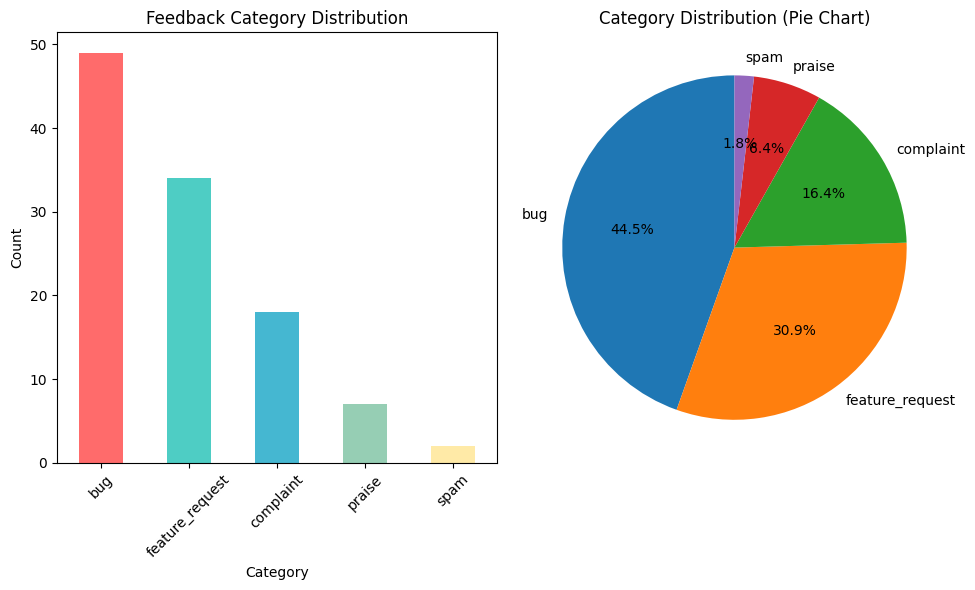

In [14]:
# Visualize category distribution
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
category_counts.plot(kind='bar', color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
plt.title('Feedback Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Category Distribution (Pie Chart)')
plt.tight_layout()
plt.show()

In [15]:

# Prepare data for model training
X = feedback_df['cleaned_text']
y = feedback_df['category']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 88
Test set size: 22


In [16]:
# TF-IDF VECTORIZATION
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,  # Limit to top 1000 features
    min_df=2,          # Ignore terms that appear in less than 2 documents
    max_df=0.8,        # Ignore terms that appear in more than 80% of documents
    stop_words='english',
    ngram_range=(1, 2)  # Use both unigrams and bigrams
)

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")

TF-IDF feature matrix shape: (88, 345)


In [17]:
# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()
print("\nTop TF-IDF features by category:")

for category in y.unique():
    # Get indices of training samples for this category
    indices = y_train[y_train == category].index
    train_indices = X_train.index.get_indexer(indices)
    train_indices = train_indices[train_indices != -1]  # Remove invalid indices

    if len(train_indices) > 0:
        # Average TF-IDF values across all documents in this category
        avg_tfidf = X_train_tfidf[train_indices].mean(axis=0).A1

        # Get indices of top 10 features
        top_feature_indices = avg_tfidf.argsort()[-10:][::-1]

        print(f"\n{category.upper()}:")
        for idx in top_feature_indices:
            score = avg_tfidf[idx]
            if score > 0:
                print(f"  {feature_names[idx]}: {score:.4f}")



Top TF-IDF features by category:

SPAM:
  offers: 0.4701
  limited time: 0.4701
  limited: 0.4701
  check: 0.4393
  time: 0.3794

BUG:
  app: 0.0745
  account: 0.0663
  data: 0.0576
  update: 0.0451
  login: 0.0450
  sync: 0.0444
  crashes: 0.0439
  work: 0.0435
  files: 0.0413
  access: 0.0402

FEATURE_REQUEST:
  app: 0.1024
  dark: 0.0900
  feature: 0.0854
  mode: 0.0648
  dark mode: 0.0578
  great: 0.0568
  theme: 0.0530
  use: 0.0506
  user: 0.0473
  add: 0.0447

COMPLAINT:
  random: 0.1286
  text: 0.1226
  asdfgh: 0.0850
  win: 0.0826
  click: 0.0772
  free: 0.0744
  instantly: 0.0744
  unreliable: 0.0715
  dont: 0.0619
  spam: 0.0570

PRAISE:
  save: 0.1272
  better: 0.1214
  time: 0.1162
  love: 0.0980
  productivity: 0.0897
  great: 0.0883
  limited time: 0.0868
  offers: 0.0868
  limited: 0.0868
  amazing: 0.0811


In [18]:
# NAIVE BAYES MODEL TRAINING
print("\n7. Training Naive Bayes Model...")

# Initialize and train Naive Bayes classifier
nb_classifier = MultinomialNB(alpha=0.25)  # Laplace smoothing
nb_classifier.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_nb = nb_classifier.predict(X_test_tfidf)

# Calculate accuracy
nb_accuracy = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")


7. Training Naive Bayes Model...
Naive Bayes Accuracy: 0.7273


In [19]:
# MODEL EVALUATION
print("\n8. Model Evaluation...")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb))


8. Model Evaluation...

Classification Report:
                 precision    recall  f1-score   support

            bug       0.75      0.75      0.75         8
      complaint       0.75      1.00      0.86         3
feature_request       0.67      0.75      0.71         8
         praise       1.00      0.50      0.67         2
           spam       0.00      0.00      0.00         1

       accuracy                           0.73        22
      macro avg       0.63      0.60      0.60        22
   weighted avg       0.71      0.73      0.71        22



d:\Agentic_AI\Capstone\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Agentic_AI\Capstone\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Agentic_AI\Capstone\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [20]:
# 9. COMPARE WITH OTHER MODELS
print("\nComparing with Other Models...")

# Initialize different models
models = {
    'Naive Bayes': MultinomialNB(alpha=0.25),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(kernel='linear', random_state=42)
}

# Train and evaluate each model
model_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train the model
    model.fit(X_train_tfidf, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_tfidf)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    cv_scores = cross_val_score(model, X_train_tfidf, y_train, cv=5)
    
    model_results[name] = {
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred
    }
    
    print(f"{name} - Accuracy: {accuracy:.4f}, CV: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


Comparing with Other Models...

Training Naive Bayes...
Naive Bayes - Accuracy: 0.7273, CV: 0.7497 (+/- 0.1400)

Training Random Forest...


d:\Agentic_AI\Capstone\venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
d:\Agentic_AI\Capstone\venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Random Forest - Accuracy: 0.7273, CV: 0.6824 (+/- 0.1899)

Training Logistic Regression...
Logistic Regression - Accuracy: 0.6364, CV: 0.6582 (+/- 0.1648)

Training SVM...
SVM - Accuracy: 0.6818, CV: 0.7392 (+/- 0.1486)


d:\Agentic_AI\Capstone\venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
d:\Agentic_AI\Capstone\venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


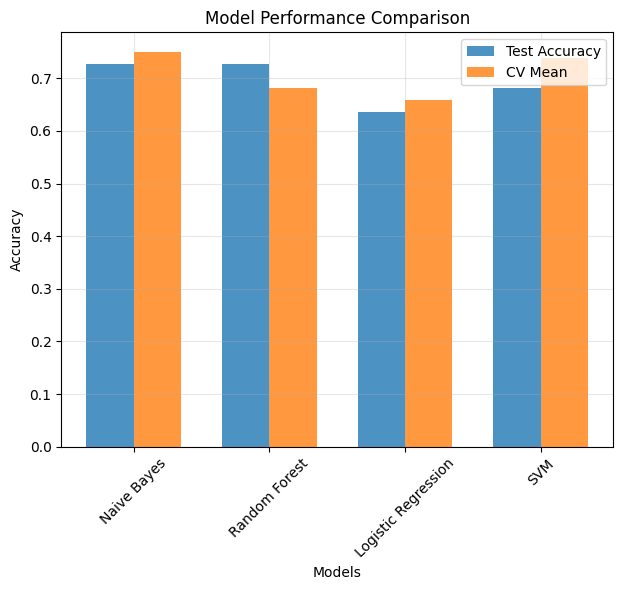

In [21]:
# Visualize model comparison
plt.figure(figsize=(12, 6))

# Accuracy comparison
plt.subplot(1, 2, 1)
model_names = list(model_results.keys())
accuracies = [model_results[name]['accuracy'] for name in model_names]
cv_means = [model_results[name]['cv_mean'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

plt.bar(x - width/2, accuracies, width, label='Test Accuracy', alpha=0.8)
plt.bar(x + width/2, cv_means, width, label='CV Mean', alpha=0.8)

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.xticks(x, model_names, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()


In [22]:
# FEATURE IMPORTANCE ANALYSIS
print("\nFeature Importance Analysis...")

# For Naive Bayes, show the most important features per class
print("\nTop features per category (Naive Bayes):")
feature_names = tfidf_vectorizer.get_feature_names_out()

for i, category in enumerate(nb_classifier.classes_):
    # Get feature log probabilities for this class
    feature_probs = nb_classifier.feature_log_prob_[i]
    top_features = np.argsort(feature_probs)[-10:][::-1]
    
    print(f"\n{category.upper()}:")
    for idx in top_features:
        print(f"  {feature_names[idx]}: {np.exp(feature_probs[idx]):.4f}")


Feature Importance Analysis...

Top features per category (Naive Bayes):

BUG:
  app: 0.0141
  account: 0.0126
  data: 0.0111
  update: 0.0089
  login: 0.0089
  sync: 0.0088
  crashes: 0.0087
  work: 0.0086
  files: 0.0083
  access: 0.0081

COMPLAINT:
  random: 0.0180
  text: 0.0173
  asdfgh: 0.0126
  win: 0.0123
  click: 0.0116
  free: 0.0113
  instantly: 0.0113
  unreliable: 0.0109
  dont: 0.0097
  spam: 0.0091

FEATURE_REQUEST:
  app: 0.0157
  dark: 0.0140
  feature: 0.0133
  mode: 0.0105
  dark mode: 0.0095
  great: 0.0093
  theme: 0.0088
  use: 0.0085
  user: 0.0080
  add: 0.0076

PRAISE:
  save: 0.0085
  better: 0.0083
  time: 0.0080
  love: 0.0071
  productivity: 0.0067
  great: 0.0067
  limited time: 0.0066
  offers: 0.0066
  limited: 0.0066
  amazing: 0.0063

SPAM:
  offers: 0.0081
  limited time: 0.0081
  limited: 0.0081
  check: 0.0078
  time: 0.0071
  using app: 0.0028
  using: 0.0028
  users: 0.0028
  user interface: 0.0028
  user experience: 0.0028


In [23]:

# SAMPLE PREDICTIONS
print("\nSample Predictions...")

# Test 
sample_texts = [
    "The app keeps crashing when I try to login",
    "Amazing app! Works perfectly and very useful",
    "Please add dark mode feature",
    "Customer service is terrible and app is too expensive", 
    "Check out this amazing product at our website for free coins"
]

sample_processed = [preprocess_text(text) for text in sample_texts]
sample_tfidf = tfidf_vectorizer.transform(sample_processed)
sample_predictions = nb_classifier.predict(sample_tfidf)
sample_probabilities = nb_classifier.predict_proba(sample_tfidf)

print("\nSample Text Classifications:")
for i, (text, pred) in enumerate(zip(sample_texts, sample_predictions)):
    print(f"\nText: '{text}'")
    print(f"Predicted Category: {pred}")
    print("Probabilities:")
    for j, category in enumerate(nb_classifier.classes_):
        print(f"  {category}: {sample_probabilities[i][j]:.3f}")


Sample Predictions...

Sample Text Classifications:

Text: 'The app keeps crashing when I try to login'
Predicted Category: bug
Probabilities:
  bug: 0.865
  complaint: 0.048
  feature_request: 0.059
  praise: 0.022
  spam: 0.005

Text: 'Amazing app! Works perfectly and very useful'
Predicted Category: feature_request
Probabilities:
  bug: 0.314
  complaint: 0.147
  feature_request: 0.456
  praise: 0.075
  spam: 0.008

Text: 'Please add dark mode feature'
Predicted Category: feature_request
Probabilities:
  bug: 0.012
  complaint: 0.017
  feature_request: 0.958
  praise: 0.010
  spam: 0.002

Text: 'Customer service is terrible and app is too expensive'
Predicted Category: bug
Probabilities:
  bug: 0.875
  complaint: 0.047
  feature_request: 0.052
  praise: 0.021
  spam: 0.005

Text: 'Check out this amazing product at our website for free coins'
Predicted Category: complaint
Probabilities:
  bug: 0.229
  complaint: 0.402
  feature_request: 0.231
  praise: 0.108
  spam: 0.029


In [24]:
# import pickle

# # Save the model and vectorizer
# with open('D:\\Agentic_AI\\Capstone\\data\\feedback_classifier.pkl', 'wb') as f:
#     pickle.dump(nb_classifier, f)
    
# with open('D:\\Agentic_AI\\Capstone\\data\\tfidf_vectorizer.pkl', 'wb') as f:
#     pickle.dump(tfidf_vectorizer, f)


In [25]:
truth_df = pd.read_csv('D:\\Agentic_AI\\Capstone\\data\\expected_classifications.csv')
truth_df.head()

,source_id,source_type,category,priority,technical_details,suggested_title
0,R001,Review,Spam,Low,Contains external promotional links (coinmaste...,Remove cryptocurrency promotional spam
1,R002,Review,Complaint,High,User reports 3-week delay in customer support ...,Reduce customer support response time for bill...
2,R003,Review,Bug,Critical,Data sync completely broken after latest updat...,Fix data synchronization failure after update ...
3,R004,Review,Bug,Critical,"Persistent 'sync failed' error, complete data ...",Resolve 'sync failed' error blocking data access
4,R005,Review,Praise,Low,User satisfaction with new collaboration featu...,Document positive feedback on collaboration fe...


In [26]:
truth_df['category'].unique()

array(['Spam', 'Complaint', 'Bug', 'Praise', 'Feature Request'],
      dtype=object)

In [27]:
truth_df.shape

(110, 6)

In [28]:
truth_df['category'].value_counts()

category
Bug                40
Feature Request    34
Spam               14
Complaint          13
Praise              9
Name: count, dtype: int64

In [29]:
feedback_df.head()

,text,source,context_info,source_id,cleaned_text,category
0,Check out this amazing crypto deal at coinmast...,review,1,R001,check out this amazing crypto deal coinmasters...,spam
1,I've been trying to reach customer support for...,review,2,R002,ive been trying reach customer support for wee...,bug
2,The data sync feature completely stopped worki...,review,1,R003,the data sync feature completely stopped worki...,feature_request
3,I can't access any of my synced data since yes...,review,1,R004,cant access any synced data since yesterday th...,bug
4,Really loving the new collaboration feature yo...,review,4,R005,really loving the new collaboration feature yo...,feature_request
